# Проект по анализу продаж интернет-магазина.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
# Загружаем файлы
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/project_1/olist_customers_dataset.csv')

orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/project_1/olist_orders_dataset.csv',\
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date'])

order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/project_1/olist_order_items_dataset.csv')

## Задание 1
Сколько у нас пользователей, которые совершили покупку только один раз?

In [3]:
# Соединяем датафреймы по ключевым полям
all_data = customers.merge(orders, how = 'outer', on = 'customer_id')
all_data = all_data.merge(order_items, how = 'outer', on = 'order_id')

Для каждого пользователя покупкой является заказ, а не товар, 
так как детализация по товару менее показательна. 
Анализ кол-ва товаров покажет объем закупки каждого пользователя. 
Но в данном случае актуальнее проверить лояльность пользователя, 
то есть как часто он заказывает в нашем магазине.

Отфильтруем заказы с подтвержденной оплатой, подтвержденной доставкой и исключим отмененные заказы.
Полагаться на статус заказа нежелательно, так как в данных есть ошибки (например, статус заказа approved, но уже проведена оплата, или статус delivered, но оплаты не было). 

In [4]:
all_data = all_data[all_data.order_approved_at.notnull() & all_data.order_delivered_customer_date.notnull() & (all_data.order_status != 'canceled')]

In [5]:
n_1 = all_data.groupby('customer_unique_id', as_index = False).aggregate({'order_id':'nunique'}) \
.rename(columns={'order_id':'orders_count'}).orders_count.value_counts()
n_1

1     90537
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: orders_count, dtype: int64

### 90537 пользователей совершили покупку только один раз.

## Задание 2
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [6]:
# Создаем детализацию по месяцам.
orders['order_purchase_new'] = orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [7]:
# Фильтруем заказы, у которых не проставлена дата доставки.
# Далее группируем по причинам и находим среднее.
n_2 = orders[orders.order_delivered_customer_date.isnull()].groupby(['order_status', 'order_purchase_new'], as_index = False) \
.agg({'order_id':'count'}).groupby('order_status', as_index = False) \
.agg({'order_id':'mean'}).rename(columns={'order_id':'orders_avg_by_month'}).sort_values('orders_avg_by_month', ascending=False)
n_2

,order_status,orders_avg_by_month
6,shipped,48.130435
7,unavailable,29.000000
1,canceled,25.791667
5,processing,15.842105
4,invoiced,14.952381
3,delivered,2.000000
2,created,1.666667
0,approved,1.000000


### Заказ мог быть не доставлен по причине отмены, отсутствия товара (unavailable) или застревания заказа на более ранних стадиях (не был оплачен, не был отгружен со склада и т.д.). Чаще всего заказ застревает на стадии отгрузки со склада.

## Задание 3
По каждому товару определить, в какой день недели товар чаще всего покупается.

In [8]:
# Находим день недели.
all_data['order_purchase_weekday'] = all_data.order_purchase_timestamp.dt.strftime('%A')

In [9]:
# Группируем по товарам и с помощью моды находим день, который встречается наиболее часто. Это позволяет учитывать случаи,
# когда максимальное кол-во продаж пришлось на несколько дней.
n_3 = all_data.groupby('product_id', as_index = False) \
.agg({'order_purchase_weekday': pd.Series.mode})
n_3

,product_id,order_purchase_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32206,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32207,fff81cc3158d2725c0655ab9ba0f712c,Monday
32208,fff9553ac224cec9d15d49f5a263411f,Friday
32209,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


## Задание 4
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [10]:
all_data['order_purchase_new'] = all_data.order_purchase_timestamp.dt.strftime('%Y-%m')
all_data['order_purchase_month'] = all_data.order_purchase_timestamp.dt.strftime('%m')

In [11]:
# Среднее кол-во покупок в месяц для каждого пользователя:
n_4 = all_data.groupby(['customer_unique_id', 'order_purchase_new'], as_index = False) \
.aggregate({'order_id':'nunique'}) \
.groupby('customer_unique_id', as_index = False) \
.agg({'order_id':'mean'}).rename(columns={'order_id':'orders_avg_by_month'}) \
.sort_values('orders_avg_by_month', ascending=False)
n_4

,customer_unique_id,orders_avg_by_month
6964,12f5d6e1cbf93dafd9dcc19095df0b3d,6.0
73113,c8460e4251689ba205045f3ea17884a1,4.0
13787,25a560b9a6006157838aab1bdbd68624,4.0
48178,83e7958a94bd7f74a9414d8782f87628,4.0
64484,b08fab27d47a1eb6deda07bfd965ad43,4.0
...,...,...
31281,55a269f324455e78349e7b9b7e7e5911,1.0
31280,55a08a9545274dc36a0c5804389217d4,1.0
31279,55a03f067a142cdde9f79f95a161b257,1.0
31278,559df1e714566692202143c82bf531ca,1.0


In [12]:
# Для подсчета среднего кол-ва покупок в неделю сначала посчитаем кол-во покупок в месяц.
n_4_1 = all_data.groupby(['customer_unique_id', 'order_purchase_new', 'order_purchase_month'], as_index = False) \
.aggregate({'order_id':'nunique'}).rename(columns={'order_id':'orders_by_month'})\
.sort_values('orders_by_month', ascending=False)

In [13]:
# Посчитаем кол-во недель в каждом месяце.
lst1 = ['04', '06', '11', '09']
lst2 = ['01', '03', '05', '07', '08', '10', '12']
def f(x):
    if x in lst1:
        return 4.29
    if x in lst2:
        return 4.43
    if x == '02':
        return 4
n_4_1['weeks'] = n_4_1.order_purchase_month.apply(f)

In [14]:
# Посчитаем кол-во покупок в неделю и найдем среднее.
n_4_1['orders_by_week'] = n_4_1.orders_by_month / n_4_1.weeks

In [15]:
n_4_1 = n_4_1.groupby('customer_unique_id', as_index = False) \
.agg({'orders_by_week':'mean'}).rename(columns={'orders_by_week':'orders_avg_by_week'}) \
.sort_values('orders_avg_by_week', ascending=False)
n_4_1

,customer_unique_id,orders_avg_by_week
6964,12f5d6e1cbf93dafd9dcc19095df0b3d,1.354402
59181,a239b8e2fbce33780f1f1912e2ee5275,1.000000
64484,b08fab27d47a1eb6deda07bfd965ad43,0.932401
13787,25a560b9a6006157838aab1bdbd68624,0.932401
73113,c8460e4251689ba205045f3ea17884a1,0.902935
...,...,...
39130,6b0fc5b03e761d5203e1441fbaf34d11,0.225734
39131,6b102c363647e94b0c8fc664a6dbdf42,0.225734
39132,6b10488724fdd3b732b505d771b2da78,0.225734
39134,6b11061762a537f7775a5a6bca7d000c,0.225734


## Задание 5
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [16]:
df5 = customers.merge(orders, how = 'outer', on = 'customer_id')
df5 = df5[df5.order_approved_at.notnull() & df5.order_delivered_customer_date.notnull() \
          & (df5.order_status != 'canceled')]

Размер когорты - месяц.
Признак - первая покупка.
Период - 3 месяца.

CRR = (Клиенты на конец периода - Клиенты, пришедшие за период) / Клиенты на начало периода * 100

CRR = (a2 - (a2 - a3)) / a1 * 100

CRR = a3 / a1 * 100

In [50]:
df5['order_purchase_datetime'] = df5.order_purchase_timestamp.apply(lambda x: x.replace(day=1, hour=0, minute=0, second=0, microsecond=0))
cohort_df = df5[['customer_unique_id', 'order_purchase_datetime', 'order_purchase_new']]


In [51]:
# Находим размер когорт
size = cohort_df.groupby('order_purchase_datetime', as_index=False).agg({'customer_unique_id':'nunique'}).rename(columns={'customer_unique_id':'cohort_size', 'order_purchase_datetime':'cohort'})

In [52]:
# Находим дату первой покупки для каждого пользователя
date_of_purch = cohort_df.groupby('customer_unique_id', as_index=False).agg({'order_purchase_datetime':'min'}).rename(columns={'order_purchase_datetime':'cohort'})

In [53]:
cohort_df = cohort_df.merge(date_of_purch)

In [54]:
cohort_df['new_purchase_3'] = cohort_df.cohort + timedelta(weeks=4.5*3)
cohort_df['new_purchase_3'] = cohort_df['new_purchase_3'].dt.strftime('%Y-%m')
users_3 = cohort_df[cohort_df.new_purchase_3 == cohort_df.order_purchase_new]

In [55]:
cohort_df['new_purchase_6'] = cohort_df.cohort + timedelta(weeks=4.5*6)
cohort_df['new_purchase_6'] = cohort_df['new_purchase_6'].dt.strftime('%Y-%m')
users_6 = cohort_df[cohort_df.new_purchase_6 == cohort_df.order_purchase_new]

In [56]:
cohort_df['new_purchase_9'] = cohort_df.cohort + timedelta(weeks=4.5*9)
cohort_df['new_purchase_9'] = cohort_df['new_purchase_9'].dt.strftime('%Y-%m')
users_9 = cohort_df[cohort_df.new_purchase_9 == cohort_df.order_purchase_new]

In [57]:
users_3 = users_3.groupby('cohort', as_index=False).agg({'customer_unique_id':'nunique'}).rename(columns={'customer_unique_id':'count_users_3'})
users_6 = users_6.groupby('cohort', as_index=False).agg({'customer_unique_id':'nunique'}).rename(columns={'customer_unique_id':'count_users_6'})
users_9 = users_9.groupby('cohort', as_index=False).agg({'customer_unique_id':'nunique'}).rename(columns={'customer_unique_id':'count_users_9'})

In [58]:
size = size.merge(users_3, how = 'outer', on='cohort').merge(users_6, how = 'outer', on='cohort').merge(users_9, how = 'outer', on='cohort')

In [59]:
size['RR_3_months'] = size.count_users_3 / size.cohort_size * 100
size['RR_6_months'] = size.count_users_6 / size.cohort_size * 100
size['RR_9_months'] = size.count_users_9 / size.cohort_size * 100

,cohort,cohort_size,count_users_3,count_users_6,count_users_9,RR_3_months,RR_6_months,RR_9_months
8,2017-06-01,3076,13.0,11.0,6.0,0.422627,0.357607,0.195059
5,2017-03-01,2508,10.0,4.0,2.0,0.398724,0.159490,0.079745
14,2017-12-01,5450,18.0,9.0,NaN,0.330275,0.165138,NaN
16,2018-02-01,6400,19.0,13.0,NaN,0.296875,0.203125,NaN
17,2018-03-01,6914,20.0,NaN,NaN,0.289268,NaN,NaN
7,2017-05-01,3478,10.0,14.0,9.0,0.287522,0.402530,0.258769
15,2018-01-01,6974,20.0,12.0,NaN,0.286779,0.172068,NaN
11,2017-09-01,4083,11.0,9.0,7.0,0.269410,0.220426,0.171443
10,2017-08-01,4114,11.0,12.0,6.0,0.267380,0.291687,0.145843
18,2018-04-01,6744,16.0,NaN,NaN,0.237248,NaN,NaN


In [60]:
cohorts_table = size.query('"2017-01-01" <= cohort <= "2017-12-01"').fillna(0).sort_values('RR_3_months', ascending=False)

In [61]:
cohorts_table

,cohort,cohort_size,count_users_3,count_users_6,count_users_9,RR_3_months,RR_6_months,RR_9_months
8,2017-06-01,3076,13.0,11.0,6.0,0.422627,0.357607,0.195059
5,2017-03-01,2508,10.0,4.0,2.0,0.398724,0.159490,0.079745
14,2017-12-01,5450,18.0,9.0,0.0,0.330275,0.165138,0.000000
7,2017-05-01,3478,10.0,14.0,9.0,0.287522,0.402530,0.258769
11,2017-09-01,4083,11.0,9.0,7.0,0.269410,0.220426,0.171443
10,2017-08-01,4114,11.0,12.0,6.0,0.267380,0.291687,0.145843
9,2017-07-01,3802,9.0,12.0,10.0,0.236718,0.315623,0.263019
6,2017-04-01,2274,4.0,8.0,4.0,0.175901,0.351803,0.175901
13,2017-11-01,7182,12.0,8.0,4.0,0.167084,0.111390,0.055695
3,2017-01-01,716,1.0,3.0,0.0,0.139665,0.418994,0.000000


### Для половины когорт Retention Rate падает с течением времени. В майской, июльской, апрельской, августовской, январской, февральской и октябрьской когортах наблюдается увеличение RR на 6 месяц.

### Когорта пользователей, совершивших покупку в июне, имеет самый высокий RR на 3-й месяц (0.42%).

## Задание 6
Построй RFM-сегментацию пользователей. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [27]:
# Посчитаем выручку по заказам.
df6 = all_data.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index = False).agg({'price': 'sum'})
df6.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [28]:
# Установим дату NOW на один день после последней покупки, чтобы параметр recency был более показателен.
NOW = df6['order_purchase_timestamp'].max() + timedelta(days=1)

In [29]:
# Расcчитаем метрики: recency - количество дней с момента последней покупки, frequency - количество покупок за исследуемый период, monetary - общая сумма покупок, сделанных за исследуемый период.

In [30]:
# Считаем кол-во дней с момента каждого заказа до даты NOW.
df6['days_since_order'] = df6['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

In [31]:
# Находим минимальное количество дней с момента покупки, кол-во заказов и сумму выручки для каждого пользователя.
aggr = {'days_since_order': 'min',
       'order_id':'count',
       'price' : 'sum'}
rfm = df6.groupby('customer_unique_id', as_index = False).agg(aggr) \
.rename(columns={'days_since_order': 'recency', 'order_id' : 'frequency', 'price' : 'monetary'})

In [32]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [33]:
# Ранжируем параметры recency, monetary и frequency. В данной системе рангов 4 - самая высокая оценка, 1 - самая низкая.
# Для recency и monetary используем квартили распределения.
quartiles = rfm[['recency', 'monetary']].quantile([.25, .5, .75]).to_dict()
quartiles

{'recency': {0.25: 114.0, 0.5: 219.0, 0.75: 346.0},
 'monetary': {0.25: 47.65, 0.5: 89.7, 0.75: 154.70000000000002}}

In [34]:
def r_score(x):
    if x <= quartiles['recency'][.25]:
        return 4
    elif x <= quartiles['recency'][.5]:
        return 3
    elif x <= quartiles['recency'][.75]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quartiles['monetary'][.25]:
        return 1
    elif x <= quartiles['monetary'][.5]:
        return 2
    elif x <= quartiles['monetary'][.75]:
        return 3
    else:
        return 4 

In [35]:
# Для frequency создадим отдельную шкалу, так как 97% пользователей сделали только 1 заказ.
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4 

In [36]:
rfm['R'] = rfm['recency'].apply(r_score)
rfm['F'] = rfm['frequency'].apply(f_score)
rfm['M'] = rfm['monetary'].apply(m_score)

In [37]:
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [38]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


In [39]:
rfm.RFM_score.value_counts()

111    5952
212    5937
311    5886
313    5835
411    5824
112    5812
413    5762
412    5643
213    5614
312    5584
211    5574
114    5496
113    5458
214    5402
314    5380
414    5378
424     429
324     424
224     357
124     289
323     165
223     163
423     162
123     140
222      93
422      90
322      85
122      78
434      44
334      35
234      33
121      30
421      26
321      26
134      23
444      22
221      15
344      15
333      14
133      10
433       6
244       6
432       4
233       4
131       3
132       2
142       2
332       2
141       1
144       1
232       1
Name: RFM_score, dtype: int64

### Сегмент с наименьшим RFM-score оказался самым крупным. Есть несколько перспективных многочисленных сегментов (413, 314, 414, 424), которые можно перевести в разряд выше, повлияв на частоту покупок. 

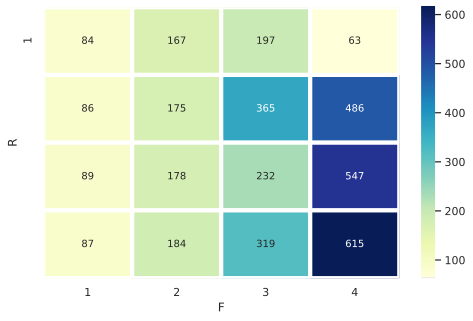

In [40]:
# Визуализация результатов
rfm_table = rfm.pivot_table(
                        index='R', 
                        columns='F', 
                        values='monetary', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)

In [41]:
# Строим границы метрик для каждого RFM-сегмента
df6_1 = rfm[['RFM_score', 'R', 'F', 'M']].drop_duplicates().reset_index(drop=True)

In [42]:
def func(a,b,c):
    if a == 4:
        e = round(rfm.recency.min())
        f = round(quartiles['recency'][.25])
    elif a == 3:
        e = round(quartiles['recency'][.25] + 1)
        f = round(quartiles['recency'][.5])
    elif a == 2:
        e = round(quartiles['recency'][.5] + 1)
        f = round(quartiles['recency'][.75])
    else:
        e = round(quartiles['recency'][.75] + 1)
        f = round(rfm.recency.max())
    if b == 4:
        g = 'от 4 до 15 заказов'
    elif b == 3:
        g = '3 заказа'
    elif b == 2:
        g = '2 заказа'
    else:
        g = '1 заказ'
    if c == 1:
        h = round(rfm.monetary.min(), 2)
        i = round(quartiles['monetary'][.25], 2)
    elif c == 2:
        h = round(quartiles['monetary'][.25] + 0.01, 2)
        i = round(quartiles['monetary'][.5], 2)
    elif c == 3:
        h = round(quartiles['monetary'][.5] + 0.01, 2)
        i = round(quartiles['recency'][.75], 2)
    else:
        h = round(quartiles['monetary'][.75] + 0.01, 2)
        i = round(rfm.monetary.max(), 2)   
    return f'Recency от {e} до {f} дней, frequency = {g} за все время, monetary от {h} до {i} рублей за все время.'

In [43]:
df6_1['borders'] = df6_1.apply(lambda x: func(x['R'], x['F'], x['M']), axis=1)

In [44]:
df6_1

,RFM_score,R,F,M,borders
0,413,4,1,3,"Recency от 1 до 114 дней, frequency = 1 заказ ..."
1,311,3,1,1,"Recency от 115 до 219 дней, frequency = 1 зака..."
2,112,1,1,2,"Recency от 347 до 714 дней, frequency = 1 зака..."
3,211,2,1,1,"Recency от 220 до 346 дней, frequency = 1 зака..."
4,214,2,1,4,"Recency от 220 до 346 дней, frequency = 1 зака..."
5,313,3,1,3,"Recency от 115 до 219 дней, frequency = 1 зака..."
6,314,3,1,4,"Recency от 115 до 219 дней, frequency = 1 зака..."
7,113,1,1,3,"Recency от 347 до 714 дней, frequency = 1 зака..."
8,111,1,1,1,"Recency от 347 до 714 дней, frequency = 1 зака..."
9,212,2,1,2,"Recency от 220 до 346 дней, frequency = 1 зака..."
